# データの準備

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path, tokenizer = None):
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    if tokenizer == None :
        tokenizer = Tokenizer(filters="")
        tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

x_train = np.load('data/x_train.npy')
x_valid = np.load('data/x_valid.npy')

# 読み込み＆Tokenizerによる数値化
y_train, tokenizer_train = load_data('data/y_train.txt')
y_valid, _ = load_data('data/y_valid.txt', tokenizer_train)

vocab_size = len(tokenizer_train.word_index) + 1

# パディング
y_train = pad_sequences(y_train, padding='post')
y_valid = pad_sequences(y_valid, padding='post')

caption_len = len(y_train[0])

/Users/yogai/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# モデル構築

## Encoder

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Lambda
from tensorflow.keras.applications.vgg16 import VGG16

K.clear_session()

encoder_input = Input(shape=(224, 224, 3))
encoder_input_normalized = Lambda(lambda x: x / 255.)(encoder_input) # [0, 255) -> [0, 1)
encoder = VGG16(weights='imagenet', include_top=False, input_tensor=encoder_input_normalized)

# パラメータを固定
for layer in encoder.layers:
    layer.trainable = False

# CNNの出力
u = Flatten()(encoder.output)

Instructions for updating:
Colocations handled automatically by placer.


## Decoder

In [3]:
from tensorflow.keras.layers import Dense, Embedding, LSTM

emb_dim = 128
hid_dim = 128

# LSTMの初期状態
decoded_states = [Dense(hid_dim)(u), Dense(hid_dim)(u)] # h_0、c_0 に対応

# 層の定義
decoder_input = Input(shape=(caption_len,))
embedding = Embedding(vocab_size, emb_dim, mask_zero=True)
lstm = LSTM(hid_dim, activation='tanh', return_sequences=True, return_state=True)

# 層の接続
decoder_embedded = embedding(decoder_input)
decoder_output, _, _ = lstm(decoder_embedded, initial_state=decoded_states) # 第2、3戻り値(最終ステップのh、c)は無視

## Attension

In [4]:
from tensorflow.keras.layers import Reshape, Activation, concatenate, dot

# 0. reshape: (7, 7, 512) -> (49, 512)
u_map = Reshape((7*7, 512))(u)

# 1. スコアの計算
dense_att = Dense(hid_dim)
score = dot([decoder_output, dense_att(u_map)], axes=-1)

# 2. 重みの計算
attention = Activation('softmax')(score)

# 3. 文脈ベクトルの計算
context = dot([attention, u_map], axes=(2,1))

# 4. 出力ベクトルの計算
attention_dense = Dense(hid_dim, activation='tanh')
output_dense = Dense(vocab_size, activation='softmax')
concat = concatenate([context, decoder_output], axis=2)
attentional = attention_dense(concat)
y_pred = output_dense(attentional)

## モデル化

In [5]:
from tensorflow.keras.models import Model

model = Model([encoder_input, decoder_input], y_pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

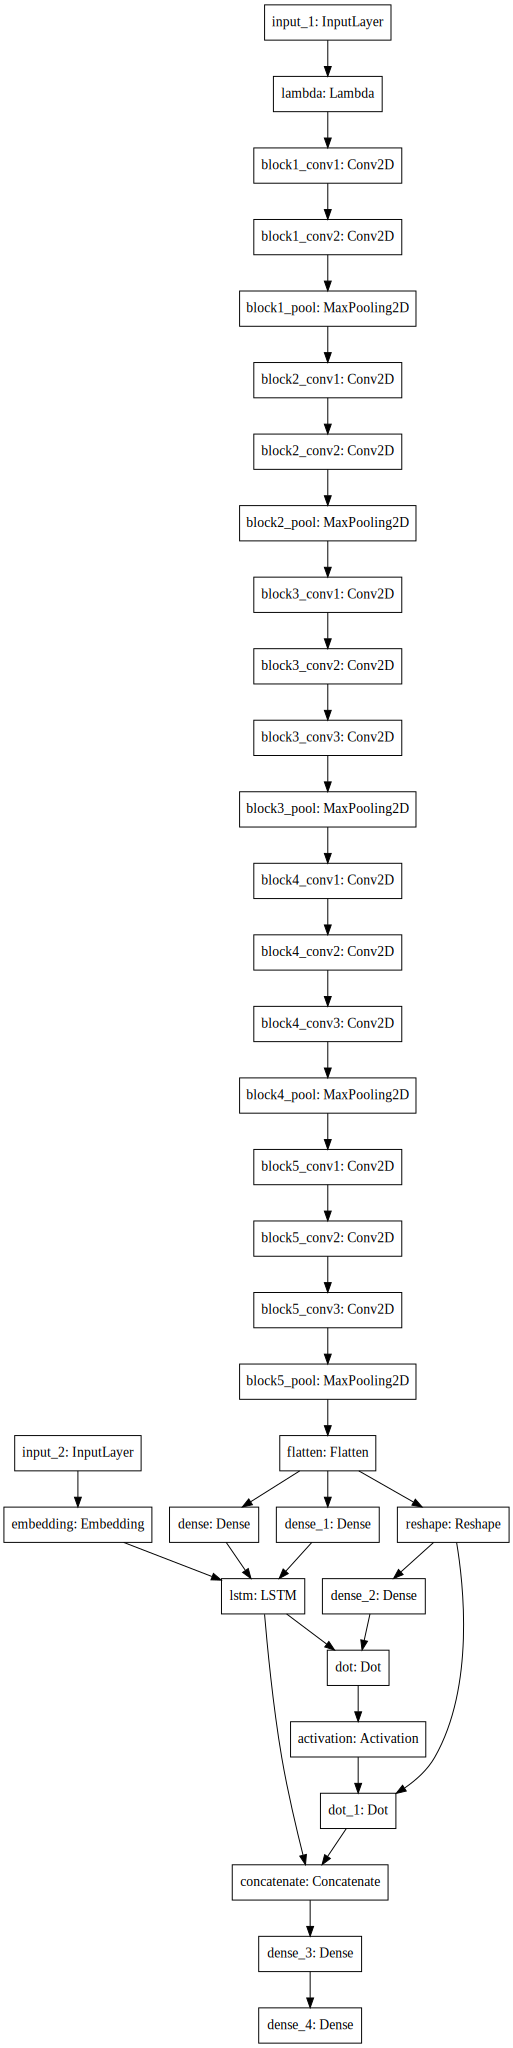

In [8]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# モデルの学習

In [9]:
# import numpy as np

# train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

# model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=64, epochs=10, verbose=1, validation_split=0.2)